# Testing Assumptions

We labeled 20203 bins as edges.
       cx    cy   cz  unmasked  synapses    weighted
4578  331  1369  277    106215       118  218.422483
4589  331  1408  277    107686       120  219.090318
4600  331  1447  277    109206       169  304.257568
4611  331  1486  277    111126       174  307.846877
4622  331  1525  277    112788       140  244.042983


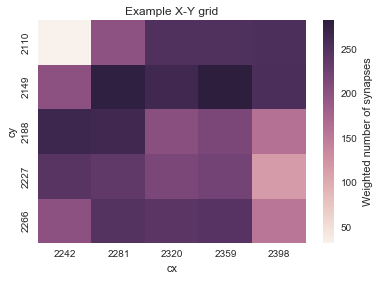

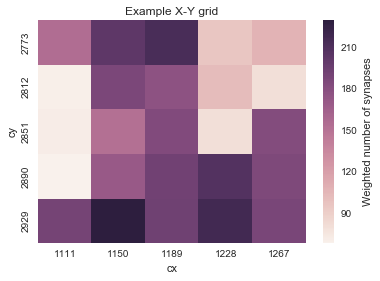

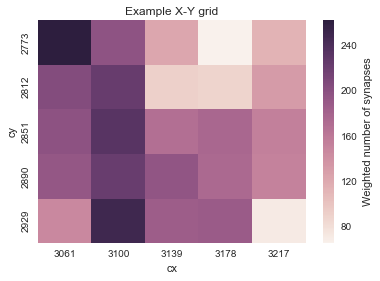

In [13]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import pickle

from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

np.random.seed(12345678)  # for reproducibility, set random seed

# Read in data
df = pd.read_csv('../output.csv')

nvox = 64*64*48 # assume number of voxels per bin
df['weighted'] = df['synapses']/df['unmasked']*nvox

xvals = df['cx'].unique()
yvals = df['cy'].unique()
zvals = df['cz'].unique()

# Get rid of the blank edges, Z-layer by Z-layer.
df['edge'] = 0

for z in zvals:
    this_z = df[df['cz']==z]
    
    # X direction
    xhist, bin_edges = np.histogram(this_z['cx'], weights = this_z['unmasked']/(nvox*len(yvals)), bins=len(xvals))
    
    left = np.argmax(xhist>0.5)
    right = len(xvals)-np.argmax(xhist[::-1]>0.5)
    
    df.loc[(df['cz']==z) & ((df['cx']<xvals[left]) | (df['cx']>=xvals[right])),'edge'] = 1
    
    # Y direction
    yhist, bin_edges = np.histogram(this_z['cy'], weights = this_z['unmasked']/(nvox*len(xvals)), bins=len(yvals))
    
    top = np.argmax(yhist>0.5)
    bottom = len(yvals)-np.argmax(yhist[::-1]>0.5)
    
    df.loc[(df['cz']==z) & ((df['cy']<yvals[top]) | (df['cy']>=yvals[bottom])),'edge'] = 1
    
print 'We labeled',np.sum(df['edge']==1),'bins as edges.'

# Copy new dataset without edges
df2 = df[df['edge']==0].copy()
df2 = df2.drop('edge', axis=1)
print df2.head()

# Restoring random state to get the same grids
with open('random_state.pickle') as f:
    rnd_state = pickle.load(f)

np.random.set_state(rnd_state)

# Generating dataset of 5x5 grids
grids = []
for z in zvals:
    
    # new xvals and yvals vary by Z layer
    nxvals = df2[df2['cz']==z]['cx'].unique()
    nyvals = df2[df2['cz']==z]['cy'].unique()
    
    for i in range(100):
        xi = np.random.randint(2,len(nxvals)-2)
        yi = np.random.randint(2,len(nyvals)-2)
        newgrid = df2[
            (df2['cx']>=nxvals[xi-2]) & (df2['cx']<=nxvals[xi+2]) & 
            (df2['cy']>=nyvals[yi-2]) & (df2['cy']<=nyvals[yi+2]) &
            (df2['cz'] == z)
            ]
        
        grids.append(newgrid)
        
        # plot examples for one Z layer
        if z==55 and i<3:
            exampleXY = pd.pivot_table(grids[i], index='cy', columns='cx', values='weighted', aggfunc=np.sum)
            plt.figure()
            sns.heatmap(exampleXY, cbar_kws={'label': 'Weighted number of synapses'});
            plt.title('Example X-Y grid');